In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datadatadata/cleaned_tv_dataset_fi.csv


In [2]:
# ============================================================
# Cell 1 - Import thư viện & Load dữ liệu
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt

# Đọc dữ liệu (CHỈNH LẠI PATH CHO ĐÚNG TRÊN KAGGLE)
df = pd.read_csv("/kaggle/input/datadatadata/cleaned_tv_dataset_fi.csv")

print("Kích thước dữ liệu:", df.shape)
display(df.head())

print("\nThông tin các cột:")
print(df.dtypes)

print("\nSố lượng giá trị thiếu mỗi cột:")
print(df.isna().sum())


Kích thước dữ liệu: (613, 12)


,price,spec_Backlight_Type,spec_Brand,spec_Display_Type,spec_ENERGY_STAR_Certified,spec_High_Dynamic_Range_HDR,spec_LED_Panel_Type,spec_Model_Year,spec_Refresh_Rate,spec_Remote_Control_Type,spec_Resolution,spec_Screen_Size_Class
0,139.99,Direct Lit,Pioneer,LED,No,Yes,Standard LED,2023,60,Voice control,4K (2160p),43
1,99.99,Direct Lit,TCL,LED,No,No,Standard LED,2025,144,Standard,Full HD (1080p),40
2,109.99,Direct Lit,Insignia,LED,No,No,Standard LED,2025,120,Voice control,Full HD (1080p),40
3,199.99,Direct Lit,Insignia,LED,No,Yes,Standard LED,2025,120,Voice control,4K (2160p),55
4,189.99,Direct Lit,Pioneer,LED,No,Yes,Standard LED,2023,60,Voice control,4K (2160p),50



Thông tin các cột:
price                          float64
spec_Backlight_Type             object
spec_Brand                      object
spec_Display_Type               object
spec_ENERGY_STAR_Certified      object
spec_High_Dynamic_Range_HDR     object
spec_LED_Panel_Type             object
spec_Model_Year                  int64
spec_Refresh_Rate                int64
spec_Remote_Control_Type        object
spec_Resolution                 object
spec_Screen_Size_Class           int64
dtype: object

Số lượng giá trị thiếu mỗi cột:
price                            0
spec_Backlight_Type            207
spec_Brand                       0
spec_Display_Type                0
spec_ENERGY_STAR_Certified       0
spec_High_Dynamic_Range_HDR      0
spec_LED_Panel_Type              0
spec_Model_Year                  0
spec_Refresh_Rate                0
spec_Remote_Control_Type         0
spec_Resolution                  0
spec_Screen_Size_Class           0
dtype: int64


In [3]:
# ============================================================
# Cell 2 - Tiền xử lý chung (General Preprocessing)
#    - Xử lý các cột text / phân loại
#    - Mã hóa One-Hot
#    - Chia train/test
# ============================================================

# 1) Chọn biến mục tiêu (y) và đặc trưng (X)
# Ở đây đề tài là "Dự đoán giá TV" nên 'price' là biến mục tiêu
target_col = "price"
y = df[target_col]
X = df.drop(columns=[target_col])

# 2) Phân loại cột numeric / categorical
# Ở dataset này:
#   - spec_Model_Year, spec_Refresh_Rate, spec_Screen_Size_Class là số
#   - Các cột spec_... kiểu object là biến phân loại (Brand, Type, Resolution,...)
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# 3) Xử lý Missing Value
# Dữ liệu này có thể đã được làm sạch, nhưng đây là nơi xử lý nếu có thiếu:
#   - numeric: có thể điền mean/median
#   - categorical: có thể điền 'Unknown'
# Ở đây kiểm tra nếu có NaN thì xử lý, nếu không thì bỏ qua.
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
X[categorical_cols] = X[categorical_cols].fillna("Unknown")

# 4) Mã hóa One-Hot cho các biến phân loại
#    - Sử dụng get_dummies để biến các cột như Brand, Type, Resolution,...

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Kích thước X sau One-Hot encoding:", X_encoded.shape)

# 5) Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)


Numeric columns: ['spec_Model_Year', 'spec_Refresh_Rate', 'spec_Screen_Size_Class']
Categorical columns: ['spec_Backlight_Type', 'spec_Brand', 'spec_Display_Type', 'spec_ENERGY_STAR_Certified', 'spec_High_Dynamic_Range_HDR', 'spec_LED_Panel_Type', 'spec_Remote_Control_Type', 'spec_Resolution']
Kích thước X sau One-Hot encoding: (613, 58)
Train size: (490, 58)  Test size: (123, 58)


In [4]:
# ============================================================
# Cell 3 - Nhánh xử lý cho SVR (Scaled Data)
#    - Tạo bản sao X_train_scaled, X_test_scaled
#    - Dùng StandardScaler
#    - Train SVR (kernel='rbf')
# ============================================================

# Giải thích rất quan trọng:
# - SVR là mô hình dựa trên Kernel + khoảng cách trong không gian đặc trưng.
# - Nếu không chuẩn hóa, các feature có độ lớn rất khác nhau
#   (ví dụ: Model_Year ~ 2023, Refresh_Rate ~ 60, Screen_Size_Class ~ 55)
#   sẽ làm khoảng cách bị chi phối bởi các biến có giá trị lớn.
# - Khi đó đường biên (hyperplane) của SVR khó tối ưu, dễ hội tụ kém,
#   R^2 có thể bị âm (tệ hơn mô hình dự đoán trung bình).
# - Vì vậy: BẮT BUỘC phải Scale dữ liệu trước khi dùng SVR.

# 1) Chuẩn hóa dữ liệu
scaler = StandardScaler()

# Chú ý: chỉ fit trên TRAIN để tránh data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2) Khởi tạo và train mô hình SVR
# Chọn C khá lớn để mô hình học linh hoạt hơn (thường cho R^2 tốt hơn)
svr_model = SVR(
    kernel="rbf",
    C=50,        # có thể thử 10, 50, 100,...
    epsilon=0.1,
    gamma="scale"
)

svr_model.fit(X_train_scaled, y_train)

# 3) Đánh giá trên tập test
y_pred_svr = svr_model.predict(X_test_scaled)

mae_svr = mean_absolute_error(y_test, y_pred_svr)
rmse_svr = mean_squared_error(y_test, y_pred_svr, squared=False)
r2_svr = r2_score(y_test, y_pred_svr)

print("===== Kết quả SVR (Scaled Data) =====")
print(f"MAE  : {mae_svr:.4f}")
print(f"RMSE : {rmse_svr:.4f}")
print(f"R^2  : {r2_svr:.4f}")


===== Kết quả SVR (Scaled Data) =====
MAE  : 385.8626
RMSE : 632.1749
R^2  : 0.3646


In [5]:
# ============================================================
# Cell 4 - Nhánh xử lý cho Random Forest (Original Data, không scale)
#    - Sử dụng trực tiếp X_train, X_test đã One-Hot
#    - Không áp dụng StandardScaler
# ============================================================

# Giải thích:
# - Random Forest là tập hợp nhiều cây quyết định (Decision Trees).
# - Cây quyết định chỉ quan tâm đến việc so sánh <, > trên từng feature độc lập
#   (ví dụ: Screen_Size_Class > 55, Model_Year <= 2021,...).
# - Cây không sử dụng khái niệm khoảng cách Euclid nên không nhạy cảm với
#   việc các feature có đơn vị khác nhau (inch, Hz, năm...).
# - Vì thế: KHÔNG CẦN scale dữ liệu cho Random Forest.
#   Thậm chí giữ nguyên giá trị gốc giúp dễ diễn giải:
#       "Screen_Size_Class > 55 inch" dễ hiểu hơn "feature_3 > 0.5 (z-score)".

rf_base = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_base.fit(X_train, y_train)

y_pred_rf = rf_base.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print("===== Kết quả Random Forest (Original Data, không scale) =====")
print(f"MAE  : {mae_rf:.4f}")
print(f"RMSE : {rmse_rf:.4f}")
print(f"R^2  : {r2_rf:.4f}")

print("\nSo sánh nhanh:")
print(f"SVR  - R^2: {r2_svr:.4f}")
print(f"RF   - R^2: {r2_rf:.4f}")


===== Kết quả Random Forest (Original Data, không scale) =====
MAE  : 241.2488
RMSE : 411.7849
R^2  : 0.7304

So sánh nhanh:
SVR  - R^2: 0.3646
RF   - R^2: 0.7304


In [6]:
# ============================================================
# Cell 5 - Tối ưu hóa Random Forest (Hyperparameter Tuning)
#    - Dùng RandomizedSearchCV để tìm hyperparameters tốt
# ============================================================

# Giải thích:
# - Random Forest có nhiều tham số ảnh hưởng mạnh đến hiệu suất:
#     + n_estimators: số cây
#     + max_depth: độ sâu tối đa mỗi cây
#     + min_samples_split, min_samples_leaf: quy định tối thiểu số mẫu để chia nhánh
#     + max_features: số lượng feature dùng ở mỗi split
# - Dùng RandomizedSearchCV giúp thử nhiều tổ hợp một cách ngẫu nhiên,
#   nhanh hơn GridSearchCV khi không gian tham số lớn.

param_distributions = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"],
}

rf_for_search = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=rf_for_search,
    param_distributions=param_distributions,
    n_iter=30,          # số tổ hợp thử; có thể tăng nếu thời gian cho phép
    cv=3,               # 3-fold cross validation
    scoring="r2",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

print("Best parameters từ RandomizedSearchCV:")
print(random_search.best_params_)
print("Best CV R^2:", random_search.best_score_)

# Lấy mô hình tốt nhất
best_rf = random_search.best_estimator_

# Đánh giá trên tập test
y_pred_best_rf = best_rf.predict(X_test)

mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
rmse_best_rf = mean_squared_error(y_test, y_pred_best_rf, squared=False)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print("\n===== Kết quả Best Random Forest trên TEST =====")
print(f"MAE  : {mae_best_rf:.4f}")
print(f"RMSE : {rmse_best_rf:.4f}")
print(f"R^2  : {r2_best_rf:.4f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best parameters từ RandomizedSearchCV:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Best CV R^2: 0.6585559781798991

===== Kết quả Best Random Forest trên TEST =====
MAE  : 252.5319
RMSE : 409.8181
R^2  : 0.7330


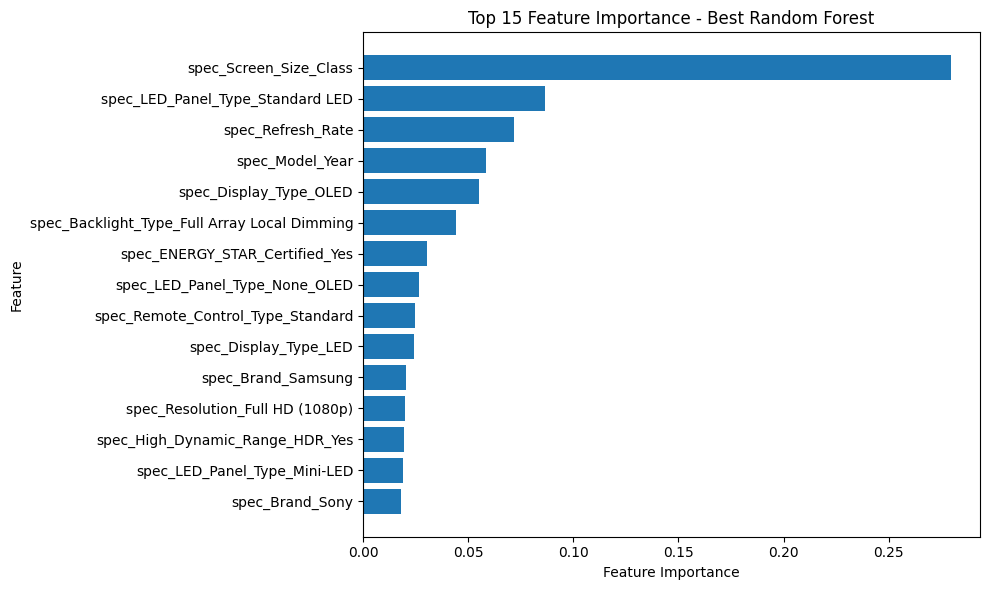

In [7]:
# ============================================================
# Cell 6 - Trực quan hóa Feature Importance (Best RF)
#    - Vẽ top 15 feature quan trọng nhất
# ============================================================

# Lấy vector importance
importances = best_rf.feature_importances_
feature_names = X_train.columns

# Đưa vào DataFrame cho dễ xử lý
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

# Sắp xếp giảm dần và lấy top 15
fi_top15 = fi_df.sort_values(by="importance", ascending=False).head(15)
fi_top15 = fi_top15[::-1]  # đảo lại để vẽ barh (feature quan trọng nhất nằm trên)

plt.figure(figsize=(10, 6))
plt.barh(fi_top15["feature"], fi_top15["importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 15 Feature Importance - Best Random Forest")
plt.tight_layout()
plt.show()


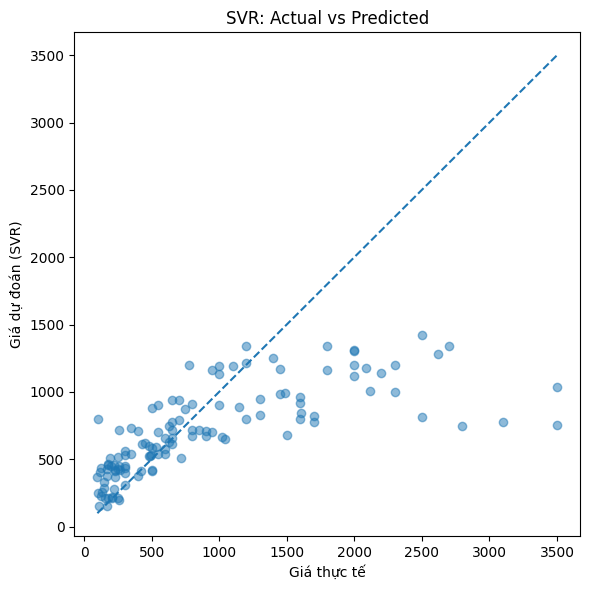

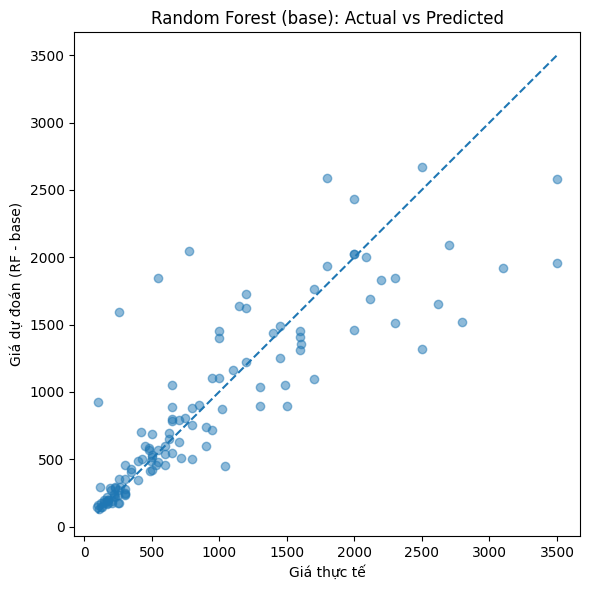

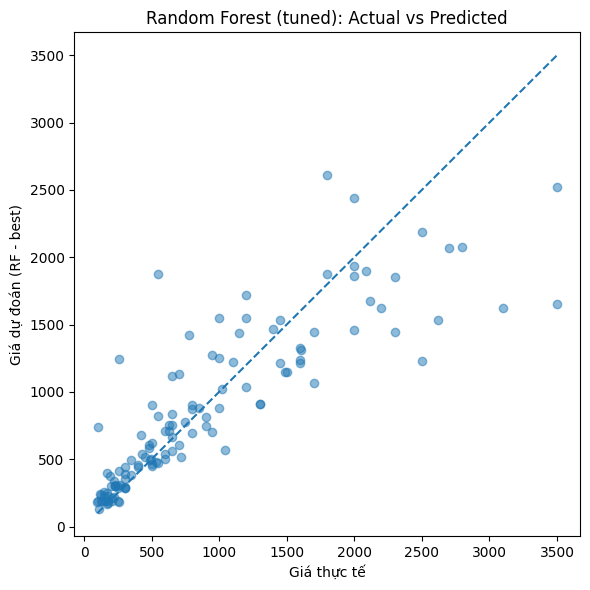

In [8]:
# ============================================================
# Cell 7 - Scatter Plot: Thực tế vs Dự đoán (SVR vs RF)
#    - Giúp so sánh trực quan giữa hai mô hình
# ============================================================

# Tạo DataFrame chung cho dễ vẽ
result_df = pd.DataFrame({
    "y_test": y_test.values,
    "SVR_pred": y_pred_svr,
    "RF_base_pred": y_pred_rf,
    "RF_best_pred": y_pred_best_rf
})

# 1) SVR vs Thực tế
plt.figure(figsize=(6, 6))
plt.scatter(result_df["y_test"], result_df["SVR_pred"], alpha=0.5)
plt.plot([result_df["y_test"].min(), result_df["y_test"].max()],
         [result_df["y_test"].min(), result_df["y_test"].max()],
         linestyle="--")
plt.xlabel("Giá thực tế")
plt.ylabel("Giá dự đoán (SVR)")
plt.title("SVR: Actual vs Predicted")
plt.tight_layout()
plt.show()

# 2) RF (base) vs Thực tế
plt.figure(figsize=(6, 6))
plt.scatter(result_df["y_test"], result_df["RF_base_pred"], alpha=0.5)
plt.plot([result_df["y_test"].min(), result_df["y_test"].max()],
         [result_df["y_test"].min(), result_df["y_test"].max()],
         linestyle="--")
plt.xlabel("Giá thực tế")
plt.ylabel("Giá dự đoán (RF - base)")
plt.title("Random Forest (base): Actual vs Predicted")
plt.tight_layout()
plt.show()

# 3) RF (best) vs Thực tế
plt.figure(figsize=(6, 6))
plt.scatter(result_df["y_test"], result_df["RF_best_pred"], alpha=0.5)
plt.plot([result_df["y_test"].min(), result_df["y_test"].max()],
         [result_df["y_test"].min(), result_df["y_test"].max()],
         linestyle="--")
plt.xlabel("Giá thực tế")
plt.ylabel("Giá dự đoán (RF - best)")
plt.title("Random Forest (tuned): Actual vs Predicted")
plt.tight_layout()
plt.show()


In [14]:
# ============================================================
# Cell 8 - Bảng so sánh Kết quả giữa SVR - RF_base - RF_best
# ============================================================

comparison_df = pd.DataFrame({
    "Model": ["SVR (Scaled)", "Random Forest (Base)", "Random Forest (Tuned)"],
    "MAE": [mae_svr, mae_rf, mae_best_rf],
    "RMSE": [rmse_svr, rmse_rf, rmse_best_rf],
    "R2 Score": [r2_svr, r2_rf, r2_best_rf]
})

# Chỉ format các cột số
numeric_cols = ["MAE", "RMSE", "R2 Score"]

comparison_df.style\
    .background_gradient(cmap="Blues", subset=numeric_cols)\
    .format("{:.4f}", subset=numeric_cols)


,Model,MAE,RMSE,R2 Score
0,SVR (Scaled),385.8626,632.1749,0.3646
1,Random Forest (Base),241.2488,411.7849,0.7304
2,Random Forest (Tuned),252.5319,409.8181,0.7330


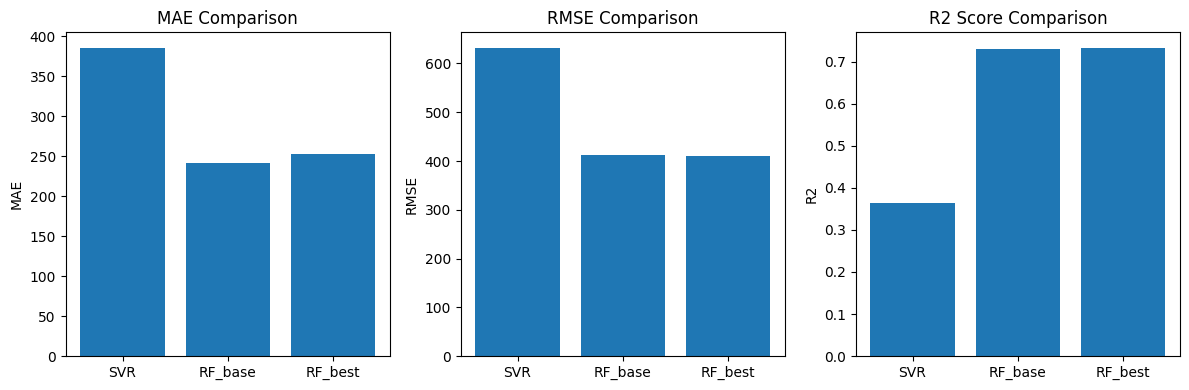

In [10]:
# ============================================================
# Cell 9 - Bar Chart so sánh R2, MAE, RMSE giữa các mô hình
# ============================================================

models = ["SVR", "RF_base", "RF_best"]

mae_vals  = [mae_svr, mae_rf, mae_best_rf]
rmse_vals = [rmse_svr, rmse_rf, rmse_best_rf]
r2_vals   = [r2_svr, r2_rf, r2_best_rf]

plt.figure(figsize=(12,4))

# MAE
plt.subplot(1,3,1)
plt.bar(models, mae_vals)
plt.title("MAE Comparison")
plt.ylabel("MAE")

# RMSE
plt.subplot(1,3,2)
plt.bar(models, rmse_vals)
plt.title("RMSE Comparison")
plt.ylabel("RMSE")

# R2 Score
plt.subplot(1,3,3)
plt.bar(models, r2_vals)
plt.title("R2 Score Comparison")
plt.ylabel("R2")

plt.tight_layout()
plt.show()


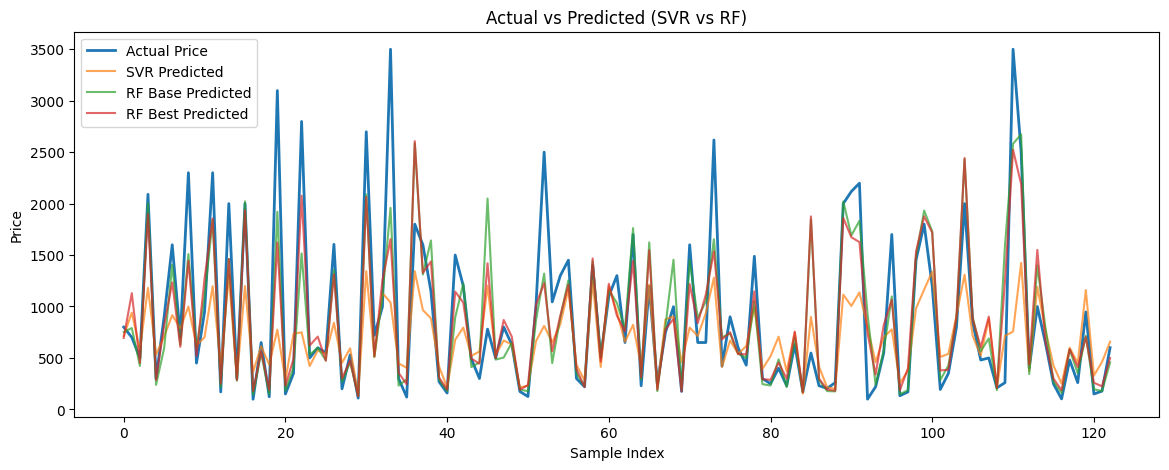

In [11]:
# ============================================================
# Cell 10 - Line chart so sánh dự đoán từng mẫu
# ============================================================

plt.figure(figsize=(14,5))

plt.plot(y_test.values[:200], label="Actual Price", linewidth=2)  # giới hạn 200 mẫu cho dễ nhìn
plt.plot(y_pred_svr[:200], label="SVR Predicted", alpha=0.7)
plt.plot(y_pred_rf[:200], label="RF Base Predicted", alpha=0.7)
plt.plot(y_pred_best_rf[:200], label="RF Best Predicted", alpha=0.7)

plt.title("Actual vs Predicted (SVR vs RF)")
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.legend()
plt.show()


In [15]:
# ============================================================
# Cell - Xuất model RF tốt nhất ra file để dùng triển khai
# ============================================================

import joblib
import json

# 1) Xuất model đã train
joblib.dump(best_rf, "best_rf_model.pkl")

# 2) Xuất danh sách tên cột (rất quan trọng khi đưa vào API/web)
feature_cols = list(X_train.columns)

with open("feature_columns.json", "w") as f:
    json.dump(feature_cols, f)

print("Đã lưu best_rf_model.pkl và feature_columns.json")


Đã lưu best_rf_model.pkl và feature_columns.json
